In [1]:
import pandas as pd
import numpy as np
import geopandas as gp
import matplotlib.pyplot as plt 
import sys
sys.path.append("..") # src exists in the parent directory
import src.config
output_name = "LastFourQuartersOrBestEstimate_On_DissolvedSmallerCitiesHexes.gpkg"
output_dir = src.config.DATA_DIRECTORY / "processed" / "statistical_geometries"

In [2]:
def convert_kbps_to_mbps(table, copy=False):
    if copy:
        table = table.copy()
    for col in table.columns:
        if "kbps" not in col:
            continue
        table.loc[:, col] /= 1000
        table.rename(columns={col: col.replace("kbps", "Mbps")}, inplace=True)
    return table

In [3]:
def load_speed_data():
    print("Loading speed data...")

    speed_data = gp.read_file(output_dir / output_name, driver="GPKG")

    speed_data["Ookla_Pop_at_50_10"] = (
        speed_data["Pop2016"] * speed_data["ookla_50_10_percentile"] / 100
    )

    speed_data = convert_kbps_to_mbps(speed_data)

    speed_data["is_rural"] = ~speed_data.PCCLASS.isin(["2", "3", "4"])

    # speed_data["PRUID"] = speed_data["PRCODE"].replace(PRCODE_MAP)
    speed_data["PCCLASS"] = speed_data["PCCLASS"].fillna("")
    return speed_data

In [4]:
def pcclass_percentage_breakdown(sample_data):
    stats_table = sample_data.groupby("PCCLASS")[
        ["Pop2016", "Pop2016_at_50_10_Combined", "Ookla_Pop_at_50_10"]
    ].sum()
    stats_table.index = pd.Index(
        pd.Series(stats_table.index)
        .replace({"2": "Small", "3": "Medium", "4": "Large", "": "Rural"})
        .values
    ).rename("Population Center Type")
    # stats_table = stats_table.append(
    #     sample_data[["Pop2016", "Pop2016_at_50_10_Combined", "Ookla_Pop_at_50_10"]]
    #     .sum()
    #     .rename("Total")
    # )
    other = sample_data[["Pop2016", "Pop2016_at_50_10_Combined", "Ookla_Pop_at_50_10"]].sum().rename("Total")
    other = pd.DataFrame(other).T
    stats_table = pd.concat([stats_table, other],axis=0)

    stats_table["Percentage_StatCan"] = (
        stats_table["Pop2016_at_50_10_Combined"] / stats_table["Pop2016"] * 100
    )
    stats_table["Percentage_Ookla"] = (
        stats_table["Ookla_Pop_at_50_10"] / stats_table["Pop2016"] * 100
    )
    stats_table.rename(
        columns={"Pop2016_at_50_10_Combined": "StatCan_Pop_at_50_10"}, inplace=True
    )

    return stats_table

In [5]:
speed_data = load_speed_data() # Half a minute to load
speed_data["Discrepancy"] = speed_data["Pop_Avail_50_10"] - speed_data["ookla_50_10_percentile"]
print(speed_data.columns)
print(np.shape(speed_data))

Loading speed data...
Index(['PCPUID', 'HEXUID_PCPUID', 'PRCODE', 'PCNAME', 'PCCLASS', 'Pop2016',
       'TDwell2016_TLog2016', 'URDwell2016_RH2016', 'PHH_Count', 'Common_Type',
       'Pop2016_at_50_10_Combined', 'TDwell2016_at_50_10_Combined',
       'URDwell_at_50_10_Combined', 'Pop_Avail_50_10', 'TDwell_Avail_50_10',
       'URDwell_Avail_50_10', 'avg_d_Mbps', 'std_d_Mbps', 'min_d_Mbps',
       'P25_d_Mbps', 'P50_d_Mbps', 'P75_d_Mbps', 'max_d_Mbps', 'avg_u_Mbps',
       'std_u_Mbps', 'min_u_Mbps', 'P25_u_Mbps', 'P50_u_Mbps', 'P75_u_Mbps',
       'max_u_Mbps', 'avg_lat_ms', 'tests', 'ave_tests_per_tile',
       'unique_devices', 'ave_devices_per_tile', 'num_tiles',
       'Down_50_percentile', 'Up_10_percentile', 'ookla_50_10_percentile',
       'min_year', 'max_year', 'connections', 'geometry', 'Ookla_Pop_at_50_10',
       'is_rural', 'Discrepancy'],
      dtype='object')
(61180, 46)


In [6]:
processed_data = pcclass_percentage_breakdown(speed_data)
processed_data.columns
processed_data

Pop2016  StatCan_Pop_at_50_10  Ookla_Pop_at_50_10   
Rural   6.577998e+06          4.484156e+06        2.952830e+06  \
Small   4.458236e+06          4.326739e+06        3.477543e+06   
Medium  3.179072e+06          3.169858e+06        2.817824e+06   
Large   2.093642e+07          2.085535e+07        1.960827e+07   
Total   3.515173e+07          3.283611e+07        2.885647e+07   

        Percentage_StatCan  Percentage_Ookla  
Rural            68.169005         44.889493  
Small            97.050458         78.002668  
Medium           99.710165         88.636673  
Large            99.612786         93.656264  
Total            93.412493         82.091177

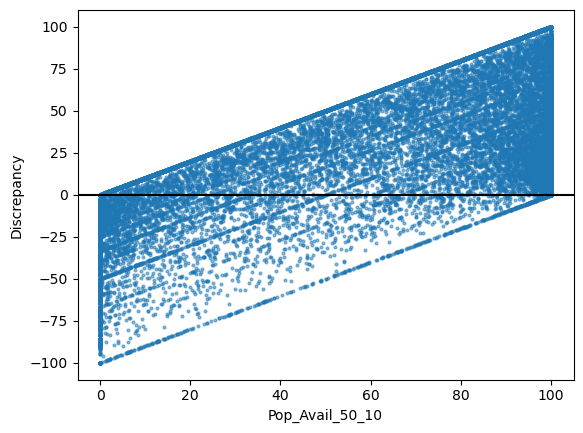

In [7]:
speed_data.plot.scatter(x="Pop_Avail_50_10", y="Discrepancy", s=4, alpha=0.5)
plt.axhline(y=0, color='k')

* Are all the large discrepancies above caused by low population/low tests entries?
* Sum along axis to quantify the overestimations and underestimations.

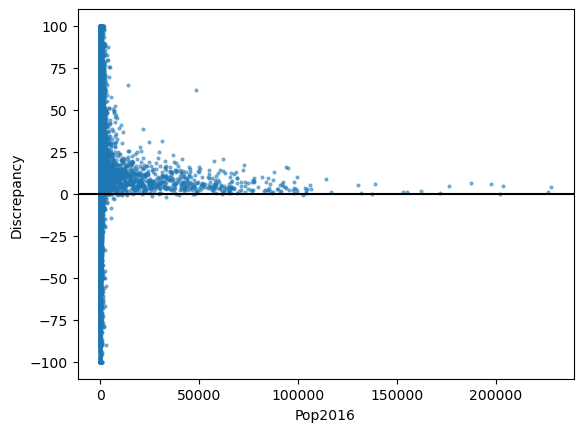

In [8]:
speed_data.plot.scatter(x="Pop2016", y="Discrepancy", s=4, alpha=0.5)
plt.axhline(y=0, color='k')
# Points close to zero discrepancy are also overestimated.

* Large discrepancies relate to low population entries.
* Large population entries have lower discrepancy but consistently overstimated speed by StatCan.

<Axes: xlabel='Pop2016', ylabel='tests'>

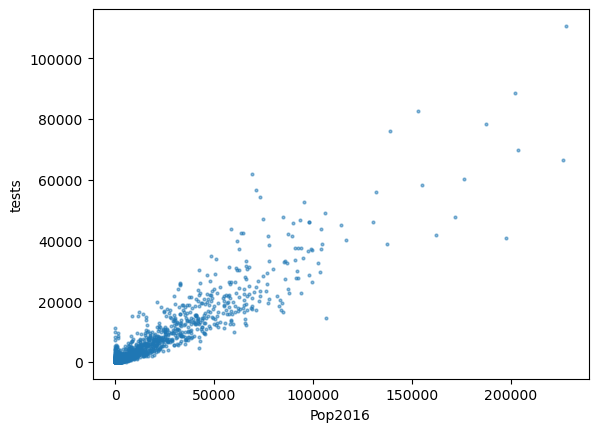

In [9]:
speed_data.plot.scatter(x="Pop2016", y="tests", s=4, alpha=0.5)
# plt.xlim(-1,100)
# plt.ylim(-1,100)
# Lots of regions with very low population

* Shows a lot of points in low tests/low population region
* How many points? Should they be discarded in the ML model?

Text(0.5, 0, 'Number of sorted rows')

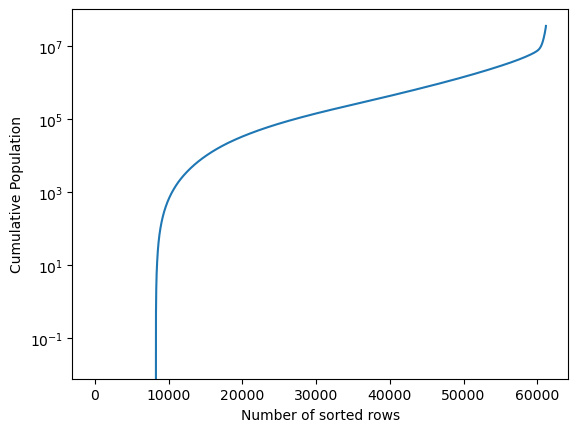

In [10]:
plt.plot(speed_data['Pop2016'].sort_values().cumsum().values)
plt.ylabel("Cumulative Population")
plt.yscale('log')
plt.xlabel("Number of sorted rows")

* About 8k entries have close to zero population.

In [11]:
speed_data['tests'].sort_values().isna().cumsum().values[-1]

13587

* Over 13k entries have nan tests.

In [12]:
speed_data[speed_data["tests"].isna()].loc[:,['Pop2016', 'PRCODE', 'PCNAME', 'PCCLASS','PCPUID', 'HEXUID_PCPUID', 'Pop_Avail_50_10', 'is_rural']].sort_values('Pop2016')

Pop2016 PRCODE           PCNAME PCCLASS  PCPUID      HEXUID_PCPUID   
58382     0.026178     BC              NaN             NaN         BC50821208  \
9161      0.030303     NL              NaN             NaN         NL46890542   
42223     0.031250     AB              NaN             NaN         AB49231100   
49970     0.031250     AB              NaN             NaN         AB49251103   
52939     0.032154     AB              NaN             NaN         AB56251117   
...            ...    ...              ...     ...     ...                ...   
731    2662.405690     BC        Vancouver       4  590973  BC49251227-590973   
1168   2894.000000     QC  Domaine-Ouellet       2  241399             241399   
521    4223.430880     ON         Hamilton       4  350349  ON43390797-350349   
549    5406.555556     ON        Kitchener       4  350419  ON43370805-350419   
165    6688.106752     QC         Montréal       4  240547  QC45410737-240547   

       Pop_Avail_50_10  is_rural  
58382         0.000000      True  
9161          0.000000      True  
42223         0.000000      True  
49970         0.000000      True  
52939         0.000000      True  
...                ...       ...  
731          98.053115     False  
1168        100.000000     False  
521         100.000000     False  
549         100.000000     False  
165         100.000000     False  

[13587 rows x 8 columns]

* Most nan tests are from low population entries.
* Some nan tests occur for moderate opulation too. What gives?

* Why are population numbers fractional? Unit conversion? or, population distributed over multiple hexes?